# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования**

Определить, рыночную стоимость автомобиля

---

**Задачи исследования**

Построить модель, которая умеет её определять

---

**Исходные данные**  

Данные находятся в файле `/datasets/autos.csv`

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя
- **Price** — цена (евро) (Целевой признак)

## Подготовка данных

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import time
import lightgbm as lgb

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    OrdinalEncoder
)
from sklearn.metrics import mean_squared_error

### Загрузка данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')

### Предобработка данных

In [4]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('размер датафрейма', name, ':', df.shape)
    print('_'*125)
    
    print('Первые 5 строк датафрейма', name)
    display(df.head())
    print('_'*125)
    
    print('Последнии 5 строк датафрейма', name)
    display(df.tail())
    print('_'*125)
    
    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)
        
    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)
    
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())
    
    print('*'*125)

In [5]:
#Объявим константы

RANDOM_STATE = 42

In [6]:
#Вызовем функцию для датасета 'data'
describe_df(data, 'data')

размер датафрейма data : (354369, 16)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма data


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма data


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


_____________________________________________________________________________________________________________________________
Информация о датафрейме data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfP

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data : 4
Количество пропусков в датафрейте data : 
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
*****************************************************************************************************************************


In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Среди признаков имеются неинформативные:
- **DateCrawled** — дата скачивания анкеты из базы
- **RegistrationMonth** — месяц регистрации автомобиля
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

Удалим их

In [8]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN


In [9]:
# Приведем название столбцов в единому стилю написания snake_case

data = data.rename(columns={'VehicleType':'vehicle_type', 
                        'RegistrationYear':'registration_year', 
                        'Gearbox':'gearbox', 
                        'Power':'power', 
                        'Model':'model', 
                        'Kilometer':'kilometer',
                        'FuelType': 'fuel_type',
                        'Brand':'brand',
                        'Repaired':'repaired',
                        'Price':'price'})

data.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN


In [10]:
#Посчитаем сколько появилось дубликатов, после удаления неинформативных столбцов

print('Количество дубликатов:', data.duplicated().sum())
print('Доля дубликатов, составляет:', data.duplicated().sum()/data.shape[0])

Количество дубликатов: 45040
Доля дубликатов, составляет: 0.1270991537070116


После удаления неинформативных признаков, количество явных дубликатов увеличилось с 4 до 45 000. Это вполне логично, ведь цена на автомобиль, не зависит от почтового индекса владельца или дата скачивания анкеты из базы. 

In [11]:
# В удалим явные дубликаты

data.drop_duplicates(inplace=True)  
data.duplicated().sum()

0

#### Вывод по предобработке данных

Данные в таблицах соответствуют описанию.

На этапе предобработки данных:
- удалили неинформативные признаки
- привели название столбцов в единому стилю написания snake_case
- удалили явные дубликаты
- убедились, что типы столбцов указаны верно

В данных есть пропуски, проработаем их на этапе исследовательского анализа данных


### Исследовательский анализ данных

In [12]:
# В целях оптимизации, напишем функцию для получения общей информации о столбце
def describe_column(df, column):
    print('Количество строк',  ':', df[column].shape[0])
    print('_'*125)
        
    print('Описание данных')
    display(df[column].describe().T)
    print('_'*125)
    
    print('Количество уникальных значений:', df[column].unique().shape[0])
    print('Количество пропусков в датафрейте', df[column].isna().sum())
    print('_'*125)
    
    if type(df[column].loc[1]) == str:
        print('Уникальные значения')
        print(df[column].value_counts())
    
    print('*'*125)

In [13]:
# Напишем функцию построения гистограммы и диграммы размаха для количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df[column].plot(ax=ax[0], kind='hist')
     
    sns.boxplot(df[column], ax=ax[1])
    
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column)
    
    ax[1].set_title('Диграмма размаха')
    ax[1].set_xlabel(column)

In [14]:
# Напишем функцию построения графика для категориальных данных

def bar_pie_plot(df, column):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df.groupby(column)[column].count().plot(ax=ax[0], kind='bar')
    
    df.groupby(column)[column].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    
        
    ax[0].set_title(f'Количественная диограмма')
    ax[1].set_title(f'Круговая диограмма')
    
    
    ax[0].tick_params(axis='x', labelrotation=90, labelsize = 15) 
    ax[1].set_ylabel('')

#### price — цена (евро)

In [15]:
#Выведем общую информацую 
describe_column(data,'price')

Количество строк : 309329
_____________________________________________________________________________________________________________________________
Описание данных


count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3731
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


Видим, что есть автомобили, которые отдают бесплатно. Посчитаем их количество

In [16]:
#бесплатные автомобили
print('Количество бесплатных автомобилей, составляет:', data[data['price'] == 0].shape[0])
print('Доля бесплатных автомобилей, составляет:', data[data['price'] == 0].shape[0]/data.shape[0])

Количество бесплатных автомобилей, составляет: 8904
Доля бесплатных автомобилей, составляет: 0.028784885995170192


Процент автомобилей, которые отдают бесплатно достаточно высок (2,8 %). Но в этой категории могут быть как автомобили, совсем не пригодные к езде и чтобы не заморачиваться с утилизацией хозяин ее отдает на запчасти, либо хозяину интересен обмен автомобиля и он решил таким образом задать цену.

In [17]:
# Удалим бесплатные автомобили
data = data[data['price'] > 0]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


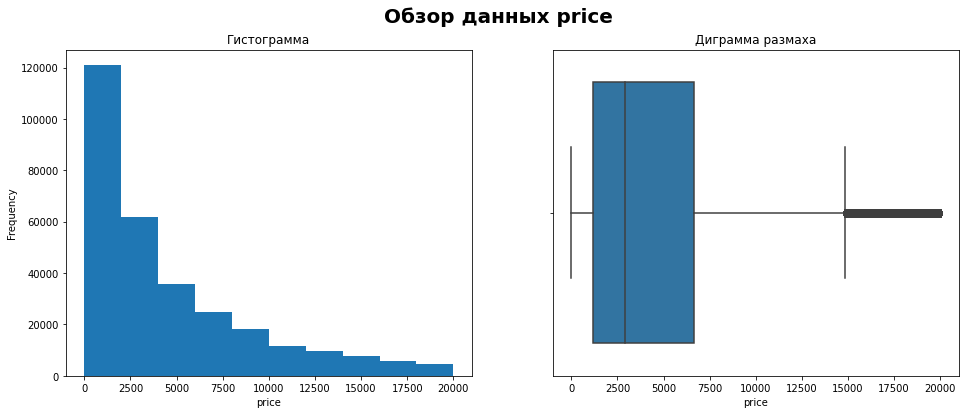

In [18]:
#Построим графики
hix_box_plot(data,'price')

In [19]:
#Процент выбросов в столбце price
print('Количество выбросов, составляет:', data[data['price'] > 15000].shape[0])
print('Доля выбросов, составляет:', data[data['price'] > 15000].shape[0]/data.shape[0])

Количество выбросов, составляет: 13615
Доля выбросов, составляет: 0.045319131230756426


**Вывод** В столбце `Price — цена (евро)`, удалили автомобили, чья стоимость равняется нулю. В столбце так же остались выбросы (автомобили дороже 15000 евро). Данные значения реалистичны, поэтому на данном этапе удалять не будем

#### vehicle_type — тип автомобильного кузова

In [20]:
#Выведем общую информацую 
describe_column(data,'vehicle_type')

Количество строк : 300425
_____________________________________________________________________________________________________________________________
Описание данных


count     268755
unique         8
top        sedan
freq       76513
Name: vehicle_type, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 9
Количество пропусков в датафрейте 31670
_____________________________________________________________________________________________________________________________
Уникальные значения
sedan          76513
small          66008
wagon          55081
bus            25455
convertible    17893
coupe          14234
suv            10596
other           2975
Name: vehicle_type, dtype: int64
*****************************************************************************************************************************


В данных огромное количество пропусков, вводить для них отдельную категорию не вижу смысла, так как есть категория other. тип Для автомобилей где не указан тип кузова проставим категорию other.            

In [21]:
# Заменим пропуски на other

data.vehicle_type.fillna('other', inplace=True)

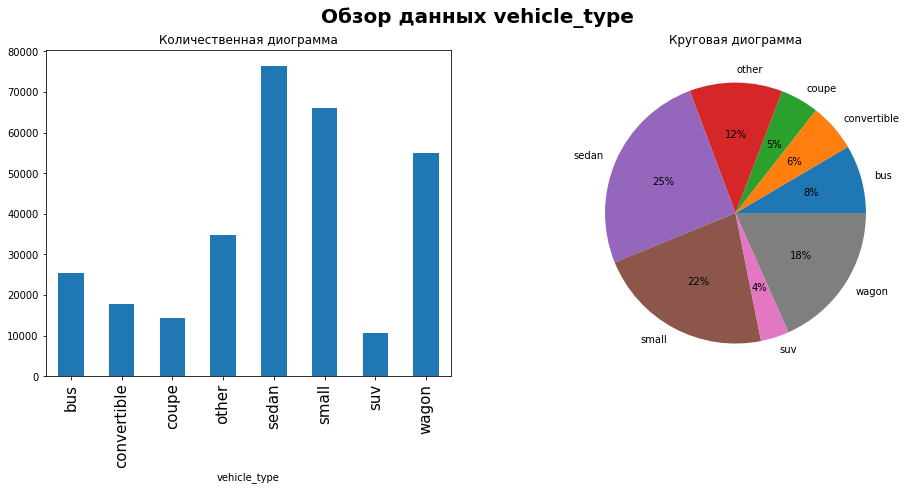

In [22]:
#Построим график 
bar_pie_plot(data, 'vehicle_type')

**Вывод** В столбце `vehicle_type — тип автомобильного кузова`, пропущенные значения заменили на 'other'

#### registration_year — год регистрации автомобиля

In [23]:
#Выведем общую информацую 
describe_column(data,'registration_year')

Количество строк : 300425
_____________________________________________________________________________________________________________________________
Описание данных


count    300425.000000
mean       2004.244916
std          83.004128
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 140
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


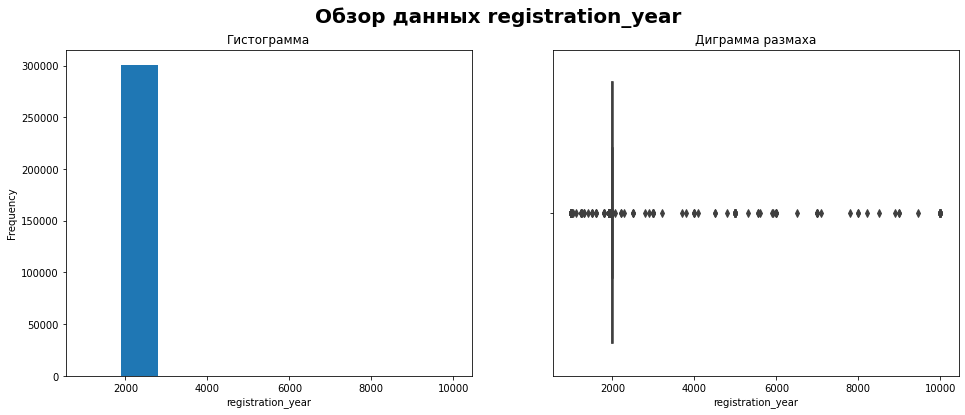

In [24]:
#Построим графики
hix_box_plot(data,'registration_year')

Поскольку в описании проекта не указано за какой период наши данные, будем ограничивать год 2023.

In [25]:
#Посчитаем сколько автомобилей зарегистрированных после 2023 года

print('Количество автомобилей выпущенных после 2023:', data[data['registration_year'] > 2023].shape[0])
print('Доля автомобилей выпущенных после 2023, составляет:', data[data['registration_year'] > 2023].shape[0]/data.shape[0])

Количество автомобилей выпущенных после 2023: 83
Доля автомобилей выпущенных после 2023, составляет: 0.0002762752766913539


In [26]:
# Удалим автомобили зарегистрированные после 2023 года
data = data[data['registration_year'] < 2023]

In [27]:
#Посмотрим какие года остались
sorted(data['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

Первые автомобили изобрели в 1885 году, а конвейерная сборка автомобилей появилась лишь в 1930. 

Определим нижнюю границу по году 1970 годом (год выпуска автомобиля ВАЗ 2001), так как ранее это уже винтажные автомобили и у них другое ценообразование.

In [28]:
#Посчитаем сколько автомобилей зарегистрированных до 1970 года

print('Количество автомобилей выпущенных до 1970:', data[data['registration_year'] < 1970].shape[0])
print('Доля автомобилей выпущенных до 1970, составляет:', data[data['registration_year'] < 1970].shape[0]/data.shape[0])

Количество автомобилей выпущенных до 1970: 1139
Доля автомобилей выпущенных до 1970, составляет: 0.0037923433951961433


In [29]:
# Удалим автомобили зарегистрированные до 1970 года
data = data[data['registration_year'] > 1970]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


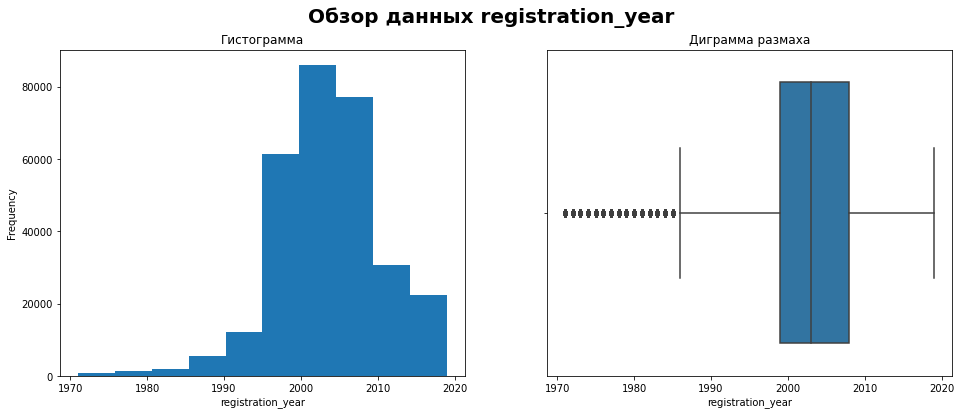

In [30]:
#Построим снова графики
hix_box_plot(data,'registration_year')

**Вывод** В столбце `registration_year — год регистрации автомобиля` оставили автомобили выпущенные с 1970-2023 года. 

#### gearbox — тип коробки передач

In [31]:
#Выведем общую информацую 
describe_column(data,'gearbox')

Количество строк : 298933
_____________________________________________________________________________________________________________________________
Описание данных


count     283990
unique         2
top       manual
freq      226094
Name: gearbox, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 14943
_____________________________________________________________________________________________________________________________
Уникальные значения
manual    226094
auto       57896
Name: gearbox, dtype: int64
*****************************************************************************************************************************


In [32]:
print('Количество пропусков', data['gearbox'].isna().sum())
print('Доля пропусков', data['gearbox'].isna().sum() / data.shape[0])

Количество пропусков 14943
Доля пропусков 0.04998778990609936


Тип коробки передач важный параметр при оценке стоимости автомобиля, заменить пропущенные значения популярным, будет некорректно. Но и терять столько данных не охото. Предлагаю, на данном этапе заменить пропуски на  "unknown".

In [33]:
# заполним пропуски значением "unknown"
data.gearbox.fillna('unknown', inplace=True)

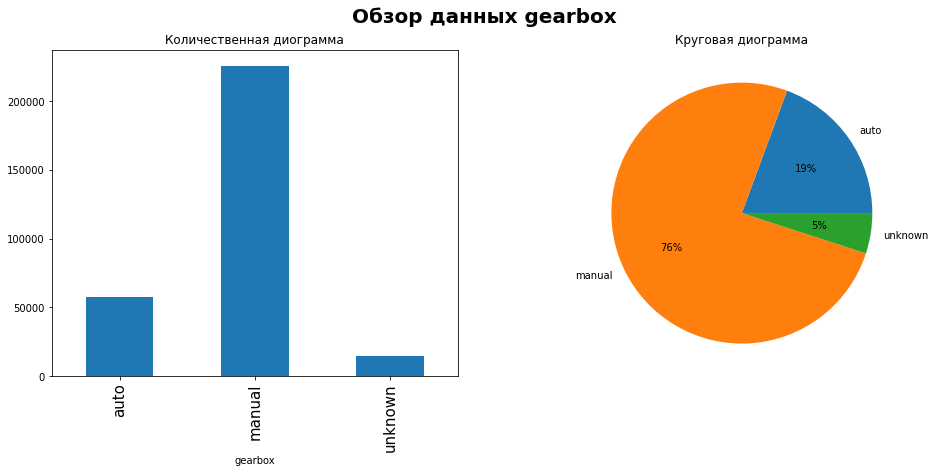

In [34]:
#Построим график 
bar_pie_plot(data, 'gearbox')

**Вывод** В столбце `gearbox — тип коробки передач` Пропущенные значения заменили на "unknown"

#### power — мощность (л. с.)

In [35]:
#Выведем общую информацую 
describe_column(data,'power')

Количество строк : 298933
_____________________________________________________________________________________________________________________________
Описание данных


count    298933.000000
mean        111.887537
std         196.898672
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 693
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


In [36]:
# Посчитаем количество строк, где мощность двигателя равна 0
print('Количество автомобилей мощностью равна 0 л.с.:', data[data['power'] == 0].shape[0])

Количество автомобилей мощностью равна 0 л.с.: 32342


Количество нулей в мощности огромно, возможно произошла ошибка, при выгрузке данных, либо пользователь забыл указать данную информацию. Заменим нули медианным значение по бренду

In [37]:
# Заменим нули медианным значение по бренду
data['power'] = data.groupby('brand')['power'].transform(lambda x: x.replace(0, x.median()))
print('Количество автомобилей мощностью равна 0 л.с.:', data[data['power'] == 0].shape[0])

Количество автомобилей мощностью равна 0 л.с.: 0


Самая маломощная машина Peel P50 (4,2 л. с.). 

In [38]:
#Посчитаем сколько автомобилей мощностью менее 4,2 л. с.

print('Количество автомобилей мощностью менее 4,2 л.с.:', data[data['power'] < 4.2].shape[0])
print('Доля автомобилей мощностью менее 4,2 л.с.:', data[data['power'] < 4.2].shape[0]/data.shape[0])

Количество автомобилей мощностью менее 4,2 л.с.: 68
Доля автомобилей мощностью менее 4,2 л.с.: 0.00022747572198452497


In [39]:
# удалим машины мощностью слабее 4,2 л.с.

data = data[data['power'] > 4.2]

Самый мощный автомобиль Devel Sixteen из ОАЭ, оснащённый в топ-версии оригинальным двигателем V16 12.3 с четырьмя турбокомпрессорами и с отдачей в 5076 л.с., сомневаюсь, что такие автомобили есть. 

Предлагаю посмотреть сколько автомобилей мощность менее 400 л.с. у нас в списке (все, что более 400 л.с. уже считаются супер карами) и цены на эти автомобили уже формируются по другому

In [40]:
#Посчитаем сколько автомобилей мощностью более 400 л.с.

print('Количество автомобилей мощностью более 400 л.с.:', data[data['power'] > 400].shape[0])
print('Количество автомобилей мощностью более 1000 л.с.:', data[data['power'] > 1000].shape[0])

print('Доля автомобилей мощностью менее более 400 л.с.:', data[data['power'] > 400].shape[0]/data.shape[0])

Количество автомобилей мощностью более 400 л.с.: 655
Количество автомобилей мощностью более 1000 л.с.: 274
Доля автомобилей мощностью менее более 400 л.с.: 0.0021916249811787933


Данных выбросов не так много, и в значениях более 5000 вероятнее всего пользователь забыл указать запятую. Например, мощность двигателя не 20 000 л.с., а всего 200 л.с., если мы захотим оставить эти данные как вариант можно поделись эти значения на 100, либо заменить медианными значениями по бренду.

Но так этих выбросов не так много, считаю правильным их удалить.

In [41]:
# удалим машины мощностью более 400 л.с.
data = data[data['power'] < 400]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


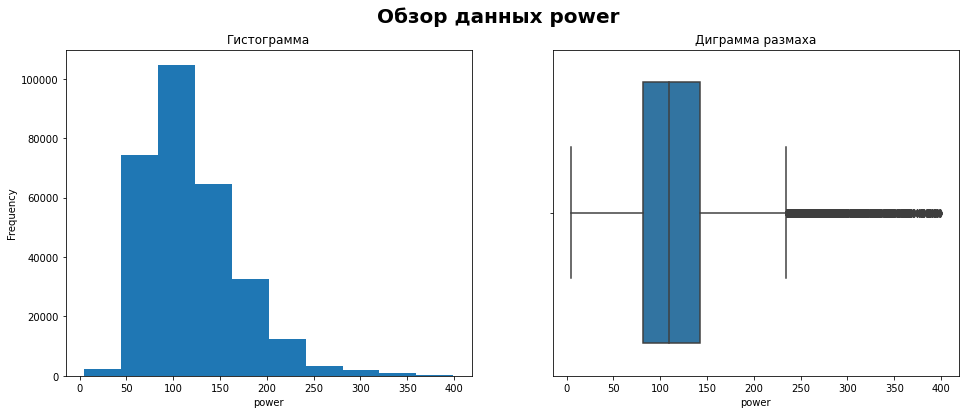

In [42]:
#Построим графики
hix_box_plot(data,'power')

**Вывод** В столбце `Power — мощность (л. с.)` заменили нули на медианное значение внутри бренда.

Удалили машины с двигателем менее 4,2 л.с. и более 400 л.с.

В данных еще остались выбросы, машины мощнее 250 л.с., но эти данные правдоподобны по значениям.

#### model — модель автомобиля

In [43]:
#Выведем общую информацую 
describe_column(data,'model')

Количество строк : 298165
_____________________________________________________________________________________________________________________________
Описание данных


count     282071
unique       250
top         golf
freq       22887
Name: model, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 251
Количество пропусков в датафрейте 16094
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


In [44]:
print('Количество пропусков', data['model'].isna().sum())
print('Доля пропусков', data['model'].isna().sum() / data.shape[0])

Количество пропусков 16094
Доля пропусков 0.053976824912380726


Модель автомобиля важный параметр при оценке стоимости автомобиля, заменить пропущенные значения популярным, будет некорректно. Но и терять столько данных не охото. Предлагаю, на данном этапе заменить пропуски на "unknown".

In [45]:
# заполним пропуски значением "unknown"
data.model.fillna('unknown', inplace=True)


In [46]:
#Проверим название марок на наличие неявных дубликатов
sorted(data.model.unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [47]:
# заменим значение 'rangerover' на 'range_rover'
data['model'] = data['model'].replace('rangerover', 'range_rover')

**Вывод** В столбце `model — модель автомобиля` Пропущенные значения заменили на "unknown", а 'rangerover' на 'range_rover'

#### kilometer — пробег (км)

In [48]:
#Выведем общую информацую 
describe_column(data,'kilometer')

Количество строк : 298165
_____________________________________________________________________________________________________________________________
Описание данных


count    298165.000000
mean     127609.695974
std       37876.993515
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 13
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


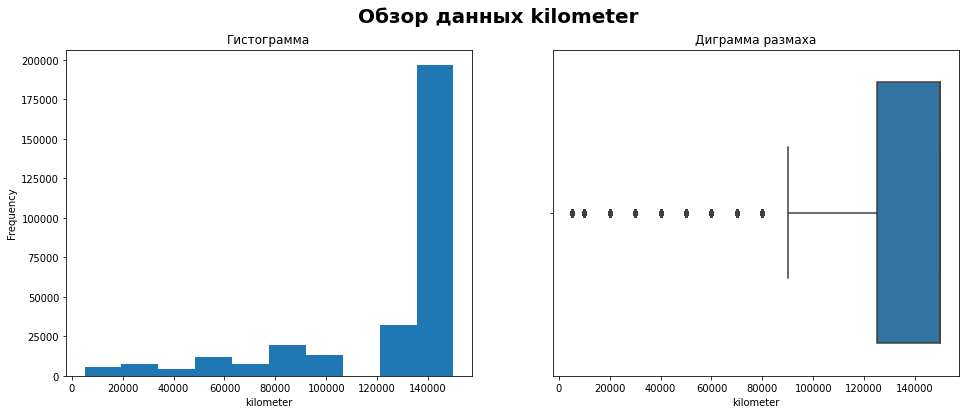

In [49]:
#Построим графики
hix_box_plot(data,'kilometer')

**Вывод** в столбце `kilometer — пробег (км)` есть выбросы, но они реалистичны по значениям, на данном этапе удалять их не будем.

#### fuel_type — тип топлива

In [50]:
#Выведем общую информацую 
describe_column(data,'fuel_type')

Количество строк : 298165
_____________________________________________________________________________________________________________________________
Описание данных


count     270661
unique         7
top       petrol
freq      181651
Name: fuel_type, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 8
Количество пропусков в датафрейте 27504
_____________________________________________________________________________________________________________________________
Уникальные значения
petrol      181651
gasoline     83324
lpg           4742
cng            509
hybrid         216
other          139
electric        80
Name: fuel_type, dtype: int64
*****************************************************************************************************************************


In [51]:
# переименуем gasoline в petrol, поскольку оба означают "бензин"
data['fuel_type'] = data['fuel_type'].replace('gasoline','petrol')

In [52]:
# Заменим пропуски на other
data.fuel_type.fillna('other', inplace=True)
print('Количество пропусков', data['fuel_type'].isna().sum())

Количество пропусков 0


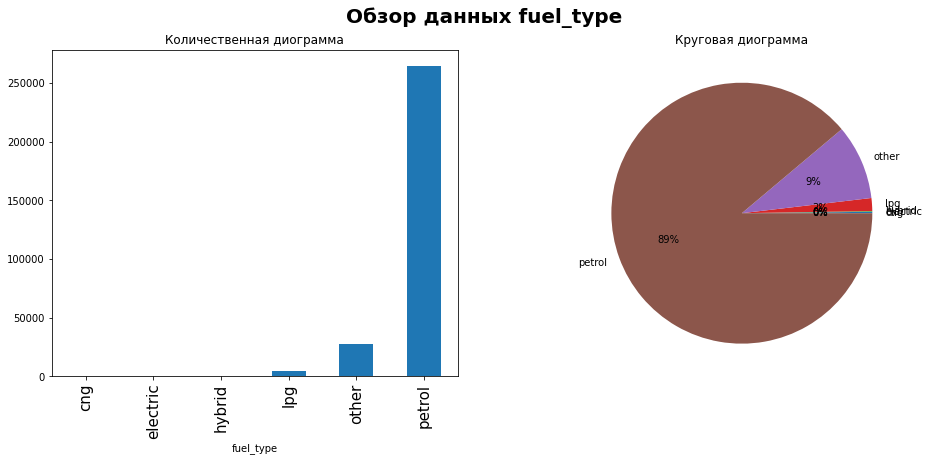

In [53]:
#Построим график 
bar_pie_plot(data, 'fuel_type')

**Вывод** В столбце `fuel_type — тип топлива` переименовали 'gasoline' в 'petrol', поскольку оба означают "бензин", пропуски заменили на 'other'

#### brand — марка автомобиля

In [54]:
#Выведем общую информацую 
describe_column(data,'brand')

Количество строк : 298165
_____________________________________________________________________________________________________________________________
Описание данных


count         298165
unique            40
top       volkswagen
freq           61556
Name: brand, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 40
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
volkswagen        61556
opel              32595
bmw               30653
mercedes_benz     27864
audi              24574
ford              21597
renault           15274
peugeot            9585
fiat               8302
seat               6013
mazda              4973
skoda              4894
smart              4749
citroen            4639
nissan             4360
toyota             4182
hyundai            3241
mini               2828
volvo              2788
mitsubishi         2717
honda              2538
sonstige_autos     2243
kia                2208
suzuki             2109
alfa_romeo         2053
chevrolet          1556
chrysler           1268
dacia    

**Вывод** В столбце `brand — марка автомобиля` данные корректны, явных дубликатов нет.

#### repaired — была машина в ремонте или нет

In [55]:
#Выведем общую информацую 
describe_column(data,'repaired')

Количество строк : 298165
_____________________________________________________________________________________________________________________________
Описание данных


count     238675
unique         2
top           no
freq      207288
Name: repaired, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 59490
_____________________________________________________________________________________________________________________________
Уникальные значения
no     207288
yes     31387
Name: repaired, dtype: int64
*****************************************************************************************************************************


In [56]:
# заполним пропуски значением "unknown"
data.repaired.fillna('unknown', inplace=True)

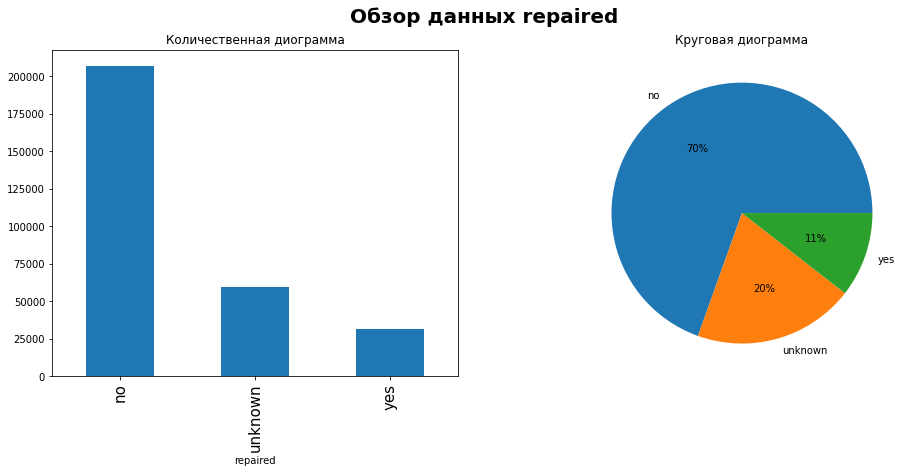

In [57]:
#Построим график 
bar_pie_plot(data, 'repaired')

**Вывод** В столбце ` repaired — была машина в ремонте или нет` Пропущенные значения заменили на "unknown"

In [58]:
# Проверим сколько дубликатов появилсь после всех преобразований данных
print('Количество дубликатов:', data.duplicated().sum())
print('Доля дубликатов, составляет:', data.duplicated().sum()/data.shape[0])

Количество дубликатов: 1183
Доля дубликатов, составляет: 0.003967601831200845


In [59]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [60]:
print('Итого, после подготовки данных удалили', (354369 - data.shape[0]), 'строки')
print(f'Процент удаленных данных, составляет: {((354369 - data.shape[0])/354369):.2%}')

Итого, после подготовки данных удалили 57387 строки
Процент удаленных данных, составляет: 16.19%


#### Вывод по исследовательскому анализу

На этапе исследовательского анализа:

- В столбце `Price — цена (евро)`, удалили автомобили, чья стоимость равняется нулю. В столбце так же остались выбросы (автомобили дороже 15000 евро). Данные значения реалистичны, поэтому на данном этапе удалять не будем

- В столбце `vehicle_type — тип автомобильного кузова`, пропущенные значения заменили на 'other'

- В столбце `registration_year — год регистрации автомобиля` оставили автомобили выпущенные с 1970-2023 года. 

- В столбце `gearbox — тип коробки передач` Пропущенные значения заменили на "unknown"

- В столбце `Power — мощность (л. с.)` заменили нули на медианное значение внутри бренда.
    Удалили машины с двигателем менее 4,2 л.с. и более 400 л.с. В данных еще остались выбросы, машины мощнее 250 л.с., но эти данные правдоподобны по значениям.
    
- В столбце `model — модель автомобиля` Пропущенные значения заменили на "unknown", а 'rangerover' на 'range_rover'

- В столбце `kilometer — пробег (км)` есть выбросы, но они реалистичны по значениям, на данном этапе удалять их не будем.

- В столбце `fuel_type — тип топлива` переименовали 'gasoline' в 'petrol', поскольку оба означают "бензин", пропуски заменили на 'other'

- В столбце `brand — марка автомобиля` данные корректны, явных дубликатов нет.

- В столбце ` repaired — была машина в ремонте или нет` Пропущенные значения заменили на "unknown"

После всех преобразований данных удалили явные дубликаты

### Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

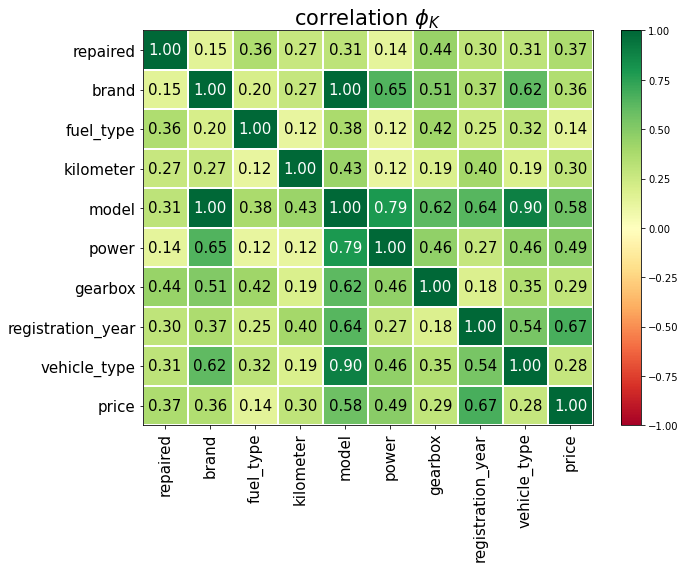

In [61]:
# вычисление коэффициентов корреляции phi для датафрейма geo_data_0
columns = ['price', 'registration_year', 'power', 'kilometer']

phik_overview = data.phik_matrix(interval_cols=columns)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8)
)

Из анализа матрицы корреляции датасета data видно, что мультиколлинеарности нет.

При этом целевой признак `price — цена (евро)`:
- Сильно коррелирует (0.67) с registration_year — год регистрации автомобиля
- Сильно коррелирует (0.58) с model — модель автомобиля
- Средне коррелирует (0.49) с power — мощность (л. с.)

Также прослеживается связь между признаками:
- model — модель автомобиля очень сильно коррелирует (0.90) с vehicle_type — тип автомобильного кузова
- brand — марка автомобиля сильно коррелирует (0.65) с power — мощность (л. с.)
- brand — марка автомобиля сильно коррелирует (0.62) с vehicle_type — тип автомобильного кузова
- model — модель автомобиля сильно коррелирует (0.79) с power — мощность (л. с.)
- model — модель автомобиля сильно коррелирует (0.64) с registration_year — год регистрации автомобиля
- model — модель автомобиля сильно коррелирует (0.62) с gearbox — тип коробки передач
- model — модель автомобиля коррелирует с brand — марка автомобиля

Все связи логичны и объяснимы, утечки целевого признака нет.

In [62]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,98.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


## Обучение моделей

### Подготовка данных

In [63]:
# зададим целевой признак и подготовим данные
X = data.drop(['price'], axis=1)
y = data['price'] 

In [64]:
# разбьём данные на обучающую, валидационную и тестовую выборки в соотношении 60:20:20
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

X_test, X_valid, y_test, y_valid = \
train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)

X.shape, X_train.shape, X_valid.shape, X_test.shape, 

((296982, 9), (178189, 9), (59397, 9), (59396, 9))

In [65]:
# создаём списки с названиями признаков
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

In [66]:
# Масштабируем количественные признаки с помощью StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_valid_scaled = scaler.transform(X_valid[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

# создадим датафрейм из закодированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_scaled.shape, X_valid_scaled.shape, X_test_scaled.shape

((178189, 3), (59397, 3), (59396, 3))

In [67]:
# выберем класс OneHotEncoder() для задачи линейной регрессии
encoder  = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_columns]) 

# кодирование валидационной выборки
X_valid_ohe = encoder.transform(X_valid[cat_columns]) 

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_columns]) 

# сохраним в переменной encoder_col_names названия новых столбцов 
encoder_col_names = encoder.get_feature_names()

# создадим датафрейм из закодированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_ohe.shape, X_valid_ohe.shape, X_test_ohe.shape

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


((178189, 304), (59397, 304), (59396, 304))

In [68]:
#Объединим все преобразованные данные в один датафреймы
X_train_ohe = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid_ohe = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test_ohe = pd.concat([X_test_ohe, X_test_scaled], axis=1)
print(X_train_ohe.shape)
print(X_valid_ohe.shape)
print(X_test_ohe.shape)

(178189, 307)
(59397, 307)
(59396, 307)


Построем гистограмму частотного распределения и ящик с усами для количественных признаков, чтобы убедиться в правильности выполнения масштабирования.

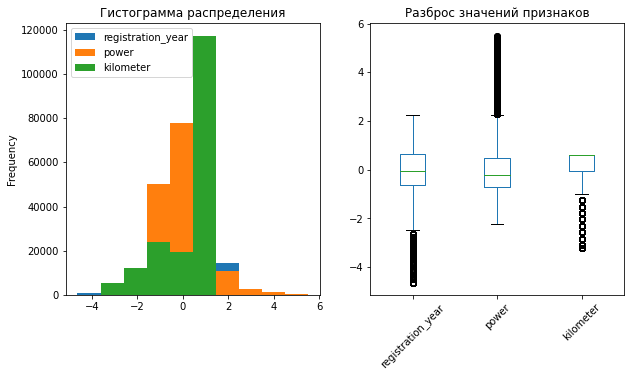

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train_ohe[num_columns].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train_ohe[num_columns].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [70]:
# выберем класс OrdinalEncoder() для остальных задач
encoder_oe = OrdinalEncoder()

# кодирование тренировочной выборки
X_train_oe = encoder_oe.fit_transform(X_train[cat_columns]) 

# кодирование валидационной выборки
X_valid_oe = encoder_oe.transform(X_valid[cat_columns]) 

# кодирование тестовой выборки
X_test_oe = encoder_oe.transform(X_test[cat_columns]) 

# сохраним в переменной encoder_col_names названия новых столбцов 
encoder_col_names = encoder_oe.get_feature_names_out()

# создадим датафрейм из закодированных данных
X_train_oe = pd.DataFrame(X_train_oe, columns=encoder_col_names)
X_valid_oe = pd.DataFrame(X_valid_oe, columns=encoder_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns=encoder_col_names)

X_train_oe.shape, X_valid_oe.shape, X_test_oe.shape

((178189, 6), (59397, 6), (59396, 6))

In [71]:
#Объединим все преобразованные данные в один датафреймы
X_train_oe = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_valid_oe = pd.concat([X_valid_oe, X_valid_scaled], axis=1)
X_test_oe = pd.concat([X_test_oe, X_test_scaled], axis=1)
print(X_train_oe.shape)
print(X_valid_oe.shape)
print(X_test_oe.shape)

(178189, 9)
(59397, 9)
(59396, 9)


Итого на данном этапе у нас два набора данных:
- X_train_ohe, X_valid_ohe, X_test_ohe - для задачи линейной регрессии
- X_train_oe, X_valid_oe, X_test_oe - для остальных задач

### Модель линейной регрессии

In [72]:
# Обучим модель линейной регрессии на подготовленных данных.

#%%time
#Найдем время обучения
start = time.time()

#Создадим модель линейной регрессии 
model_lr  = LinearRegression()

#обучим модель на тренировочных данных
model_lr.fit(X_train_ohe, y_train)

end = time.time()
time_lr_fit = end-start


In [73]:
%%time
#Найдем время обучения
start = time.time()

# получим предсказания модели на валидационных данных 
predictions_lr = model_lr.predict(X_valid_ohe) 

end = time.time()
time_lr_predict = end-start

CPU times: user 114 ms, sys: 76.1 ms, total: 190 ms
Wall time: 189 ms


In [74]:
rmse_lr =  mean_squared_error(y_valid, predictions_lr, squared=False)

print('Метрика RMCE:', round(rmse_lr, 2))
print('Время обучения модели:', round(time_lr_fit, 2), 'сек.')
print('Время предсказания модели:', round(time_lr_predict, 2), 'сек.')

Метрика RMCE: 2662.52
Время обучения модели: 20.11 сек.
Время предсказания модели: 0.19 сек.


### Decision Tree Regressor

In [75]:
# построим модель для решающего дерева и найдем наилучшие гиперпараметры
# найдем лучшие гиперпараметры для глубины дерева
for depth in range(3, 15, 3):
    model = DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth = depth)
    model.fit(X_train_oe, y_train)
    predictions_tr = model.predict(X_valid_oe)
    rmse = mean_squared_error(y_valid, predictions_tr, squared=False)
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')
print()

Глубина: 3
RMSE для решающего дерева: 2999.8106526668903

Глубина: 6
RMSE для решающего дерева: 2354.6445108205426

Глубина: 9
RMSE для решающего дерева: 2105.7485662757476

Глубина: 12
RMSE для решающего дерева: 2007.2833970460902




Ограничим глубину дерева 9, так как модель склонна к переобучению

In [76]:
# Обучим модель Decision Tree Regressor на подготовленных данных.

#%%time
#Найдем время обучения
start = time.time()

#Создадим модель линейной регрессии 
model_tr  = DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth = 9)

#обучим модель на тренировочных данных
model_tr.fit(X_train_oe, y_train)

end = time.time()
time_tr_fit = end-start

In [77]:
%%time
#Найдем время обучения
start = time.time()

# получим предсказания модели на валидационных данных 
predictions_tr = model_tr.predict(X_valid_oe) 

end = time.time()
time_tr_predict = end-start

CPU times: user 8 ms, sys: 880 µs, total: 8.88 ms
Wall time: 7.21 ms


In [78]:
rmse_tr =  mean_squared_error(y_valid, predictions_tr, squared=False)

print('Метрика RMCE:', round(rmse_tr, 2))
print('Время обучения модели:', round(time_tr_fit, 2), 'сек.')
print('Время предсказания модели:', round(time_tr_predict, 2), 'сек.')

Метрика RMCE: 2105.75
Время обучения модели: 0.35 сек.
Время предсказания модели: 0.01 сек.


### LightGBM

In [79]:
# Создание и обучение модели LightGBM
lgb_train = lgb.Dataset(X_train_oe, y_train)
lgb_test = lgb.Dataset(X_valid_oe, y_valid, reference=lgb_train)

params = {'objective': 'regression',
          'metric': 'rmse', 
          'max_depth':9,
          'random_state': RANDOM_STATE,
          'learning_rate':0.1}

#%%time
#Найдем время обучения
start = time.time()

#обучим модель на тренировочных данных
lgbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                verbose_eval=100)

end = time.time()
time_lgbm_fit = end-start

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 178189, number of used features: 9
[LightGBM] [Info] Start training from score 4609.532496


In [80]:
%%time
#Найдем время предсказания
start = time.time()

# получим предсказания модели на валидационных данных 
predictions_lgbm = lgbm.predict(X_valid_oe, num_iteration=lgbm.best_iteration)

end = time.time()
time_lgbm_predict = end-start

CPU times: user 273 ms, sys: 0 ns, total: 273 ms
Wall time: 300 ms


In [81]:
# Оценка модели
rmse_lgbm = mean_squared_error(y_valid, predictions_lgbm, squared=False)
print('Метрика RMCE:', round(rmse_lgbm, 2))
print('Время обучения модели:', round(time_lgbm_fit, 2), 'сек.')
print('Время предсказания модели:', round(time_lgbm_predict, 2), 'сек.')

Метрика RMCE: 1853.78
Время обучения модели: 3.37 сек.
Время предсказания модели: 0.3 сек.


## Анализ моделей

In [82]:
# Создадим датафрйм с результатами
results = pd.DataFrame({'Модель': ['Linear Regression', 'Decision Tree Regressor', 'LightGBM'],
                        'RMCE': [rmse_lr, rmse_tr, rmse_lgbm],
                        'Время обучения модели': [time_lr_fit, time_tr_fit, time_lgbm_fit],
                        'Время предсказания модели': [time_lr_predict, time_tr_predict, time_lgbm_predict]})
display(results)

,Модель,RMCE,Время обучения модели,Время предсказания модели
0,Linear Regression,2662.522819,20.109901,0.188873
1,Decision Tree Regressor,2105.748566,0.345732,0.007188
2,LightGBM,1853.783466,3.367735,0.299930


Лучшая модель LightGBM, на валидационной выборке оценка качества модели RMSE 1853.78, при этом эта модель обучалась дольше всех 32 секунды.

Модель Decision Tree Regressor	оказалась самой быстрой, время обучения 0,32 секунды, оценка качества модели RMSE на валидационной выборке 2105,75, что удовлетворяет условия задачи (меньше 2500).

Модель Linear Regression справилась хуже всех, RMSE на валидационной выборке 2662,52, что превышает требуемый показатель. 

Проверим качество лучшей модели LightGBM на тестовой выборке

In [83]:
%%time
#Найдем время предсказания
start = time.time()

# получим предсказания модели на валидационных данных 
predictions = lgbm.predict(X_test_oe, num_iteration=lgbm.best_iteration)

end = time.time()
time_lgbm_predict_finish = end-start

CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 268 ms


In [84]:
# Оценка модели
rmse_lgbm = mean_squared_error(y_test, predictions, squared=False)
print('Метрика RMCE:', round(rmse_lgbm, 2))
print('Время предсказания модели:', round(time_lgbm_predict_finish, 2), 'сек.')

Метрика RMCE: 1861.59
Время предсказания модели: 0.27 сек.


Лучшая модель на тестовых данных показала отличные результаты. 

## Анализ важности признаков

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

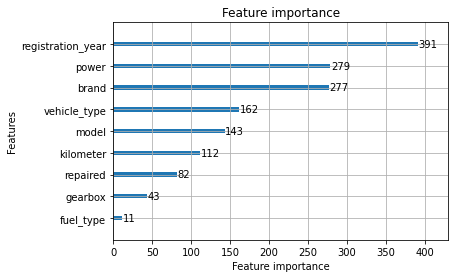

In [85]:
lgb.plot_importance(lgbm)

Самым важным признаком в нашей модели оказался registration_year — год регистрации автомобиля. Также на стоимость автомобиля сильно влияют power — мощность (л. с.) и brand — марка автомобиля, самый незначительный признак fuel_type — тип топлива

## Общий вывод

**Определение стоимости автомобилей**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования**

Определить, рыночную стоимость автомобиля

---

**Задачи исследования**

Построить модель, которая умеет её определять

---

**Исходные данные**  

Данные находятся в файле `/datasets/autos.csv`

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя
- **Price** — цена (евро) (Целевой признак)

---

**Предобработка данных**

На этапе предобработки данных:
- удалили неинформативные признаки
- привели название столбцов в единому стилю написания snake_case
- удалили явные дубликаты
- убедились, что типы столбцов указаны верно

В данных остались пропуски, которые проработали их на этапе исследовательского анализа данных.

---

**Исследовательский анализ данных**

На этапе исследовательского анализа:

- В столбце `Price — цена (евро)`, удалили автомобили, чья стоимость равняется нулю. В столбце так же остались выбросы (автомобили дороже 15000 евро). Данные значения реалистичны, поэтому на данном этапе удалять не будем

- В столбце `vehicle_type — тип автомобильного кузова`, пропущенные значения заменили на 'other'

- В столбце `registration_year — год регистрации автомобиля` оставили автомобили выпущенные с 1970-2023 года. 

- В столбце `gearbox — тип коробки передач` Пропущенные значения заменили на "unknown"

- В столбце `Power — мощность (л. с.)` заменили нули на медианное значение внутри бренда.
    Удалили машины с двигателем менее 4,2 л.с. и более 400 л.с. В данных еще остались выбросы, машины мощнее 250 л.с., но эти данные правдоподобны по значениям.
    
- В столбце `model — модель автомобиля` Пропущенные значения заменили на "unknown", а 'rangerover' на 'range_rover'

- В столбце `kilometer — пробег (км)` есть выбросы, но они реалистичны по значениям, на данном этапе удалять их не будем.

- В столбце `fuel_type — тип топлива` переименовали 'gasoline' в 'petrol', поскольку оба означают "бензин", пропуски заменили на 'other'

- В столбце `brand — марка автомобиля` данные корректны, явных дубликатов нет.

- В столбце ` repaired — была машина в ремонте или нет` Пропущенные значения заменили на "unknown"

После всех преобразований данных удалили явные дубликаты

--- 

**Корреляционный анализ**

Из анализа матрицы корреляции датасета data видно, что мультиколлинеарности нет.

При этом целевой признак `price — цена (евро)`:
- Сильно коррелирует (0.67) с registration_year — год регистрации автомобиля
- Сильно коррелирует (0.58) с model — модель автомобиля
- Средне коррелирует (0.49) с power — мощность (л. с.)

Также прослеживается связь между признаками:
- model — модель автомобиля очень сильно коррелирует (0.90) с vehicle_type — тип автомобильного кузова
- brand — марка автомобиля сильно коррелирует (0.65) с power — мощность (л. с.)
- brand — марка автомобиля сильно коррелирует (0.62) с vehicle_type — тип автомобильного кузова
- model — модель автомобиля сильно коррелирует (0.79) с power — мощность (л. с.)
- model — модель автомобиля сильно коррелирует (0.64) с registration_year — год регистрации автомобиля
- model — модель автомобиля сильно коррелирует (0.62) с gearbox — тип коробки передач
- model — модель автомобиля коррелирует с brand — марка автомобиля

Все связи логичны и объяснимы, утечки целевого признака нет.

---

**Обучение моделей**

На данном этапе была проведена подготовка данных.

в качестве моделей рассматривались: 'Linear Regression', 'Decision Tree Regressor', 'LightGBM'

Для 'Linear Regression':
- Метрика RMCE: 2675.23
- Время обучения модели: 21.41 сек.
- Время предсказания модели: 0.21 сек.

Для 'Decision Tree Regressor':
- Метрика RMCE: 2114.99
- Время обучения модели: 3.81 сек.
- Время предсказания модели: 0.07 сек.

Для 'LightGBM':
- Метрика RMCE: 1845.54
- Время обучения модели: 156.86 сек.
- Время предсказания модели: 0.56 сек.

---

**Анализ моделей**

Лучшая модель LightGBM, на валидационной выборке оценка качества модели RMSE 1853.78, при этом эта модель обучалась дольше всех 32 секунды.

Модель Decision Tree Regressor	оказалась самой быстрой, время обучения 0,32 секунды, оценка качества модели RMSE на валидационной выборке 2105,75, что удовлетворяет условия задачи (меньше 2500).

Модель Linear Regression справилась хуже всех, RMSE на валидационной выборке 2662,52, что превышает требуемый показатель. 

---

**Предсказание на тестовых данных**

Лучшая модель (LightGBM) на тестовых данных показала отличные результаты.

- Метрика RMCE: 1861.59
- Время предсказания модели: 0.25 сек.

---

**Анализ важности признаков**

Самым важным признаком в нашей модели оказался registration_year — год регистрации автомобиля. Также на стоимость автомобиля сильно влияют power — мощность (л. с.) и brand — марка автомобиля, самый незначительный признак fuel_type — тип топлива